### Import

In [48]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [49]:
dtypes = {
    'defaultPaymentMethod': str,
    'mode': str,
    'serviceClassificationName': str,
    'state': str,
    'address_county': str,
    'address_district': str,
    'discount_type': str,
    'subtotal': float,
    'travelingExpense': float,
    'discountNum': float,
    'isServicePackageBooking': float
}

In [50]:
df_main = pd.read_csv(
    r'C:\Users\USER\OneDrive\Documents\DSC_Project\20250517_資料集\一般訂單\main.csv',
    dtype=dtypes,
    low_memory=False
)

### Feature engineering

#### 1. days_until_next_order


In [51]:
# Feature engineering (unchanged)
df_date_only = df_main['createdAt']
df_date_only = pd.to_datetime(df_date_only)
df_date_only = df_date_only.dt.date
df_main['only_date'] = df_date_only

df_main = df_main.sort_values(['user_oid', 'only_date']).reset_index(level=0, drop=True)
df_main['only_date'] = pd.to_datetime(df_main['only_date'])
df_main['next_order_date'] = df_main.groupby('user_oid')['only_date'].shift(-1)
df_main['next_order_date'] = pd.to_datetime(df_main['next_order_date'])
df_main['days_until_next_order'] = (df_main['next_order_date'] - df_main['only_date']).dt.days


In [52]:
#Drop data after the cut-off point.

df_date_only = pd.to_datetime(df_date_only, errors="raise")

# Find the latest date in the 'createdAt' column
latest_date = df_date_only.max()

# Calculate the date 360 days before the latest date
cut_off_date = latest_date - pd.Timedelta(days=365)

# Drop rows where 'createdAt' is before the cut-off date
df_main = df_main[df_date_only <= cut_off_date]

print(f"DataFrame shape after dropping rows: {df_main.shape}")

DataFrame shape after dropping rows: (17427, 88)


#### 2. orders_last_365d

In [53]:
df_tmp = pd.DataFrame(df_main.groupby("user_oid").rolling("360D", on='only_date')['only_date'].count().shift(1).fillna(0).reset_index(level=0, drop=True))
df_tmp.columns = ['orders_last_365d']
df_tmp.reset_index(inplace=True)
df_main['orders_last_365d'] = df_tmp['orders_last_365d']

### 3. prev_mode

In [54]:
df_main["prev_mode"] = df_main.groupby("user_oid")["mode"].shift(1)
df_main['first_order'] = df_main['prev_mode'].apply(lambda x: 1 if pd.isna(x) else 0)
df_main["prev_mode"] = df_main["prev_mode"].fillna('general')

### 4. same_mode_as_last

In [55]:
df_main['same_mode_as_last'] = (df_main['mode'] == df_main['prev_mode'])

### Data preperation

In [56]:
# Data preparation (excluding address_hasElevator)  DROP 'address_district' DROP 'mode',  ,'discount_type'(缺失太多)  ,'orders_last_365d'   
num_cols = ['subtotal', 'discountNum','orders_last_365d']
cat_cols = ['defaultPaymentMethod', 'serviceClassificationName','state','address_county'  
            ,"prev_mode",'same_mode_as_last','isServicePackageBooking','first_order']

# Define X and y
X = df_main[num_cols + cat_cols].copy()
y = df_main['days_until_next_order'].copy()

for col in cat_cols:
    X[col] = X[col].astype(str)  # Ensure categorical columns are strings
    
y = y.apply(lambda x: 0 if pd.isna(x) or x > 365 else 1)
groups = df_main["user_oid"]


### Minimal preprocessing block

In [57]:
# Preprocessing pipeline
prep = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline(steps=[
            ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols)
    ],
    remainder='drop'
)

### Model and Pipline

In [58]:
lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    random_state=42,
    class_weight='balanced'
)
pipe = Pipeline([('prep', prep), ('model', lgbm)])

### Train / Test split

In [59]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

### Fit

In [60]:
pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
pred_proba = pipe.predict_proba(X.iloc[test_idx])[:, 1]  # Probabilities for Class 1

[LightGBM] [Info] Number of positive: 4763, number of negative: 9176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 13939, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Find Optimal Threshold (Youden's J statistic)

In [61]:
fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], pred_proba)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

### Adjust predictions based on the optimal threshold
pred_adjusted = (pred_proba >= optimal_threshold).astype(int)

Optimal Threshold (Youden's J): 0.4829


### Eval

#### Accuracy

In [62]:
print(f"\nAccuracy (Adjusted Threshold): {accuracy_score(y.iloc[test_idx], pred_adjusted):.2f}")
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y.iloc[test_idx], pred_adjusted))


Accuracy (Adjusted Threshold): 0.69

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2322
           1       0.54      0.57      0.56      1166

    accuracy                           0.69      3488
   macro avg       0.66      0.66      0.66      3488
weighted avg       0.70      0.69      0.70      3488



#### Confusion Matrix

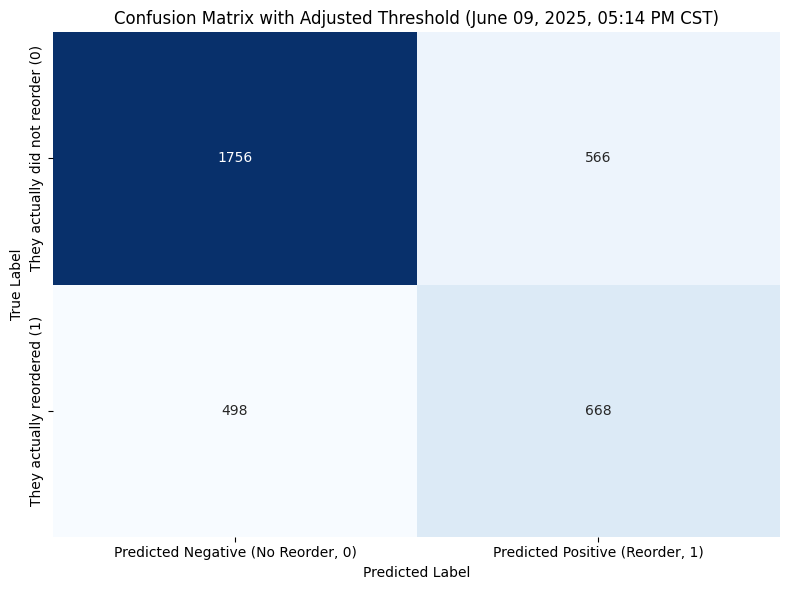

In [63]:
cm_adjusted = confusion_matrix(y.iloc[test_idx], pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative (No Reorder, 0)', 'Predicted Positive (Reorder, 1)'],
            yticklabels=['They actually did not reorder (0)', 'They actually reordered (1)'])
plt.title('Confusion Matrix with Adjusted Threshold (June 09, 2025, 05:14 PM CST)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### Normalize CM

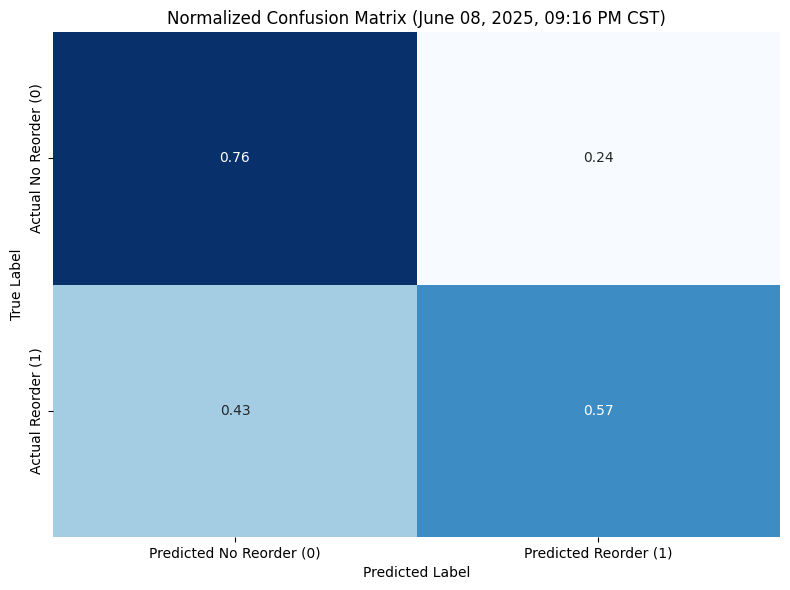

In [64]:
cm_normalized = cm_adjusted.astype('float') / cm_adjusted.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Reorder (0)', 'Predicted Reorder (1)'],
            yticklabels=['Actual No Reorder (0)', 'Actual Reorder (1)'])
plt.title('Normalized Confusion Matrix (June 08, 2025, 09:16 PM CST)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### ROC & AUC Curve

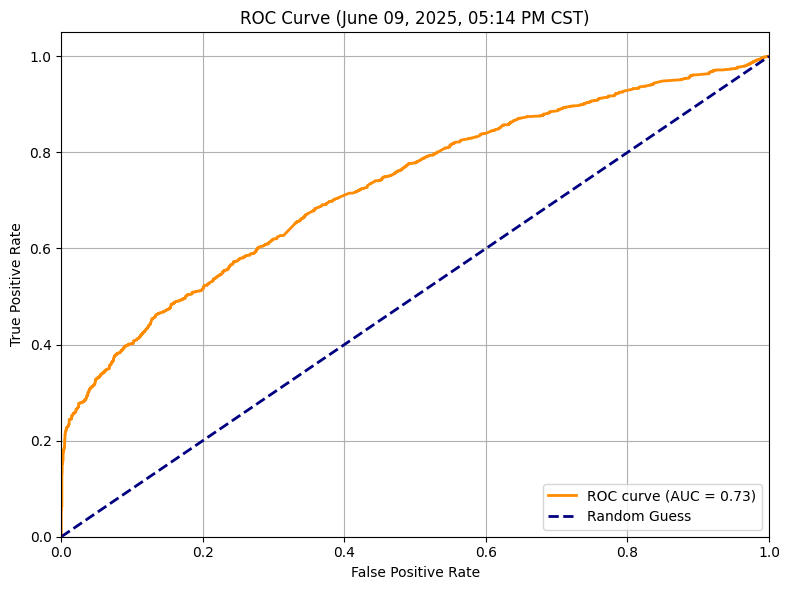

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y.iloc[test_idx], pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (June 09, 2025, 05:14 PM CST)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### G-Mean

In [66]:
recall_0 = cm_adjusted[0, 0] / (cm_adjusted[0, 0] + cm_adjusted[0, 1])
recall_1 = cm_adjusted[1, 1] / (cm_adjusted[1, 0] + cm_adjusted[1, 1])
gmean = np.sqrt(recall_0 * recall_1)
print(f"\nG-Mean (Adjusted Threshold): {gmean:.4f}")
print(f"Recall Class 0 (Specificity): {recall_0:.4f}")
print(f"Recall Class 1 (Sensitivity): {recall_1:.4f}")


G-Mean (Adjusted Threshold): 0.6582
Recall Class 0 (Specificity): 0.7562
Recall Class 1 (Sensitivity): 0.5729
